# Flights Data Exploration Challenge

In this challenge, you'll explore a real-world dataset containing flights data from the US Department of Transportation.

Let's start by loading and viewing the data.

The dataset contains observations of US domestic flights in 2013, and consists of the following fields:

- **Year**: The year of the flight (all records are from 2013)
- **Month**: The month of the flight
- **DayofMonth**: The day of the month on which the flight departed
- **DayOfWeek**: The day of the week on which the flight departed - from 1 (Monday) to 7 (Sunday)
- **Carrier**: The two-letter abbreviation for the airline.
- **OriginAirportID**: A unique numeric identifier for the departure aiport
- **OriginAirportName**: The full name of the departure airport
- **OriginCity**: The departure airport city
- **OriginState**: The departure airport state
- **DestAirportID**: A unique numeric identifier for the destination aiport
- **DestAirportName**: The full name of the destination airport
- **DestCity**: The destination airport city
- **DestState**: The destination airport state
- **CRSDepTime**: The scheduled departure time
- **DepDelay**: The number of minutes departure was delayed (flight that left ahead of schedule have a negative value)
- **DelDelay15**: A binary indicator that departure was delayed by more than 15 minutes (and therefore considered "late")
- **CRSArrTime**: The scheduled arrival time
- **ArrDelay**: The number of minutes arrival was delayed (flight that arrived ahead of schedule have a negative value)
- **ArrDelay15**: A binary indicator that arrival was delayed by more than 15 minutes (and therefore considered "late")
- **Cancelled**: A binary indicator that the flight was cancelled

Your challenge is to explore the flight data to analyze possible factors that affect delays in departure or arrival of a flight.

1. Start by cleaning the data.
    - Identify any null or missing data, and impute appropriate replacement values.
    - Identify and eliminate any outliers in the **DepDelay** and **ArrDelay** columns.
2. Explore the cleaned data.
    - View summary statistics for the numeric fields in the dataset.
    - Determine the distribution of the **DepDelay** and **ArrDelay** columns.
    - Use statistics, aggregate functions, and visualizations to answer the following questions:
        - *What are the average (mean) departure and arrival delays?*
        - *How do the carriers compare in terms of arrival delay performance?*
        - *Is there a noticable difference in arrival delays for different days of the week?*
        - *Which departure airport has the highest average departure delay?*
        - *Do **late** departures tend to result in longer arrival delays than on-time departures?*
        - *Which route (from origin airport to destination airport) has the most **late** arrivals?*
        - *Which route has the highest average arrival delay?*
        
Add markdown and code cells as required to create your solution.

> **Note**: There is no single "correct" solution. A sample solution is provided in [01 - Flights Challenge.ipynb](01%20-%20Flights%20Solution.ipynb).

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import plotly.express as px

from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('data/flights.csv')
df.head()

,Year,Month,DayofMonth,DayOfWeek,Carrier,OriginAirportID,OriginAirportName,OriginCity,OriginState,DestAirportID,DestAirportName,DestCity,DestState,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
0,2013,9,16,1,DL,15304,Tampa International,Tampa,FL,12478,John F. Kennedy International,New York,NY,1539,4,0.0,1824,13,0,0
1,2013,9,23,1,WN,14122,Pittsburgh International,Pittsburgh,PA,13232,Chicago Midway International,Chicago,IL,710,3,0.0,740,22,1,0
2,2013,9,7,6,AS,14747,Seattle/Tacoma International,Seattle,WA,11278,Ronald Reagan Washington National,Washington,DC,810,-3,0.0,1614,-7,0,0
3,2013,7,22,1,OO,13930,Chicago O'Hare International,Chicago,IL,11042,Cleveland-Hopkins International,Cleveland,OH,804,35,1.0,1027,33,1,0
4,2013,5,16,4,DL,13931,Norfolk International,Norfolk,VA,10397,Hartsfield-Jackson Atlanta International,Atlanta,GA,545,-1,0.0,728,-9,0,0


### Restoring missing values

For more convenient access to the data, we visualize the entire dataset on the missing data.

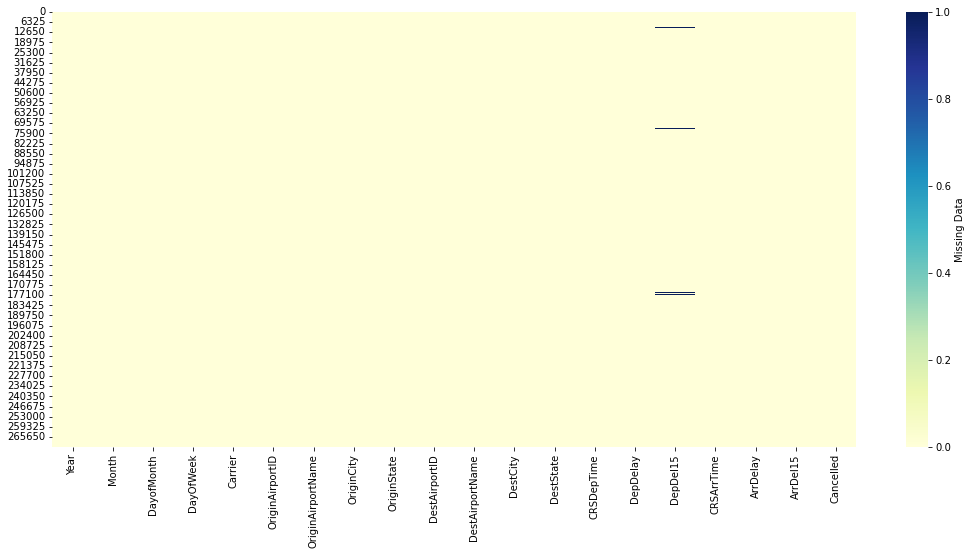

In [4]:
plt.figure(figsize=(18, 8))
sns.heatmap(df.isnull(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("Visualizing_missing_data")

We find that there is a small amount of missing data in the **DepDel15** column. This column answers whether the flight was delayed by more than 15 minutes. We have to consider a delay column with zero values for subsequent conclusions.

In [5]:
df[df.isnull().any(axis=1)][['DepDelay','DepDel15']]

,DepDelay,DepDel15
171,0,NaN
359,0,NaN
429,0,NaN
545,0,NaN
554,0,NaN
...,...,...
271410,0,NaN
271607,0,NaN
271634,0,NaN
271671,0,NaN


It looks like every null value corresponds to NaN.

In [6]:
df[df.isnull().any(axis=1)].DepDelay.value_counts()

0    2761
Name: DepDelay, dtype: int64

We can safely replace missing values with zeros.

In [7]:
df['DepDel15'] = df['DepDel15'].fillna(0)

### Identifying and eliminate any outliers in the DepDelay and ArrDelay

Let's see distribution for our two columns

In [8]:
def show_distribution(var_data):
    # get statistics
    min_val = var_data.min()
    max_val = var_data.max()
    mean_val = var_data.mean()
    med_val = var_data.median()
    mod_val = var_data.mode()[0]
    
    print('Minimum:{:.2f}'.format(min_val))
    print('Max.value:{:.2f}'.format(max_val))
    print('Mean:{:.2f}'.format(mean_val))
    print('Median:{:.2f}'.format(med_val))
    print('Mode.value:{:.2f}'.format(med_val))
    
    # creating plot
    fig, ax = plt.subplots(2, 1, figsize = (10, 4))
    
    # histogram
    ax[0].hist(var_data)
    ax[0].set_ylabel('Freq.')
    
    # creating statistical lines
    ax[0].axvline(x=min_val, color='black', ls='-', lw=1, label='Minimal')
    ax[0].axvline(x=max_val, color='black', ls='-', lw=1)
    ax[0].axvline(x=mean_val, color='red', ls='-', lw=1)
    ax[0].axvline(x=med_val, color='blue', ls='-', lw=1)
    ax[0].axvline(x=mod_val, color='yellow', ls='-', lw=1)
    
    # boxplot
    ax[1].boxplot(var_data, vert=False)
    ax[1].set_xlabel('Value')
    
    fig.suptitle(var_data.name)
    fig.show()

Minimum:-63.00
Max.value:1425.00
Mean:10.35
Median:-1.00
Mode.value:-1.00


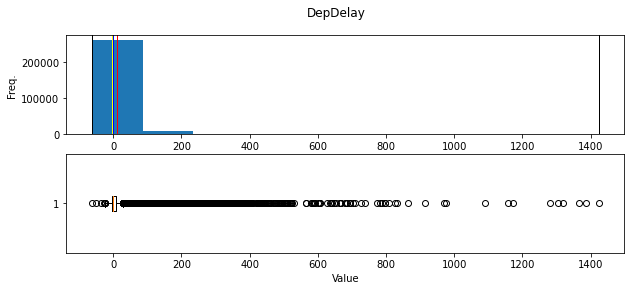

In [9]:
show_distribution(df['DepDelay'])

Minimum:-75.00
Max.value:1440.00
Mean:6.50
Median:-3.00
Mode.value:-3.00


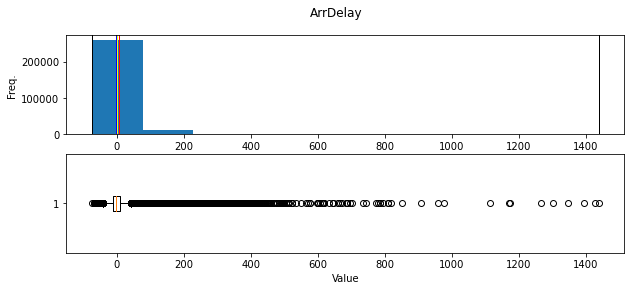

In [10]:
show_distribution(df['ArrDelay'])

There are a outliers particularly at the upper end.
It sounds logical to trim data for including only fields between 5th and 90th percentile.

In [11]:
lower_bound_dep_delay = df['DepDelay'].quantile(0.05)
upper_bound_dep_delay = df['DepDelay'].quantile(0.90)
lower_bound_arr_delay = df['ArrDelay'].quantile(0.05)
upper_bound_arr_delay = df['ArrDelay'].quantile(0.90)

df = df[df['DepDelay'] < upper_bound_dep_delay]
df = df[df['DepDelay'] > lower_bound_dep_delay]

df = df[df['ArrDelay'] < upper_bound_arr_delay]
df = df[df['ArrDelay'] > lower_bound_arr_delay]

Minimum:-7.00
Max.value:36.00
Mean:2.32
Median:-1.00
Mode.value:-1.00
---
Minimum:-22.00
Max.value:37.00
Mean:-1.43
Median:-3.00
Mode.value:-3.00


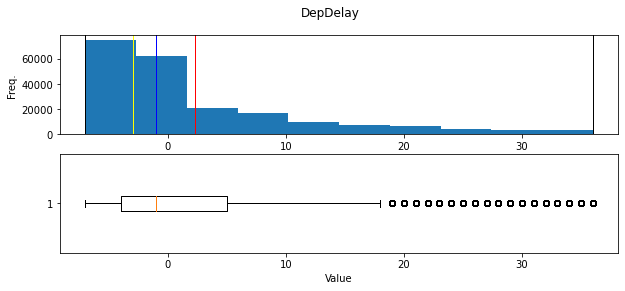

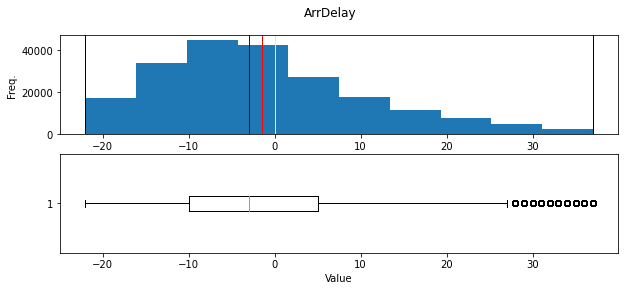

In [12]:
show_distribution(df['DepDelay'])
print('---')
show_distribution(df['ArrDelay'])

Looks a little bit better.

### View summary statistics for the numeric fields in the dataset.

In [13]:
df.describe()

,Year,Month,DayofMonth,DayOfWeek,OriginAirportID,DestAirportID,CRSDepTime,DepDelay,DepDel15,CRSArrTime,ArrDelay,ArrDel15,Cancelled
count,208854.0,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000,208854.000000
mean,2013.0,6.999196,15.823882,3.901448,12741.745861,12738.344121,1302.697650,2.315747,0.116162,1484.172546,-1.434624,0.128903,0.013627
std,0.0,1.990908,8.818289,1.989333,1510.899138,1514.014783,467.638173,9.114443,0.320420,487.112998,12.162406,0.335094,0.115936
min,2013.0,4.000000,1.000000,1.000000,10140.000000,10140.000000,1.000000,-7.000000,0.000000,1.000000,-22.000000,0.000000,0.000000
25%,2013.0,5.000000,8.000000,2.000000,11292.000000,11292.000000,905.000000,-4.000000,0.000000,1110.000000,-10.000000,0.000000,0.000000
50%,2013.0,7.000000,16.000000,4.000000,12892.000000,12892.000000,1300.000000,-1.000000,0.000000,1505.000000,-3.000000,0.000000,0.000000
75%,2013.0,9.000000,23.000000,6.000000,14057.000000,14057.000000,1705.000000,5.000000,0.000000,1900.000000,5.000000,0.000000,0.000000
max,2013.0,10.000000,31.000000,7.000000,15376.000000,15376.000000,2359.000000,36.000000,1.000000,2359.000000,37.000000,1.000000,1.000000


#### Let's find out distribution of the DepDelay and ArrDelay columns.

Mean departure delay

In [14]:
df['DepDelay'].mean()

2.315746885384048

Mean arrival delay

In [15]:
df['ArrDelay'].mean()

-1.4346241872312715

#### How do the month compare to arrival and departure delays?

In [16]:
delay_fields = ['DepDelay','ArrDelay']

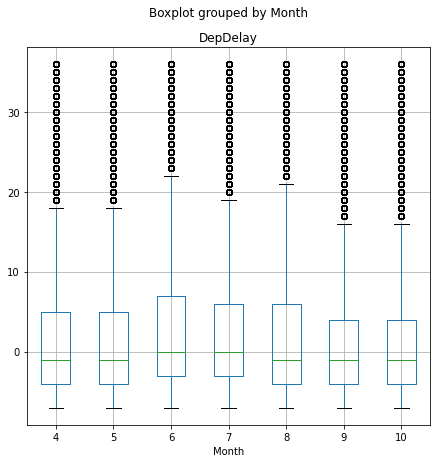

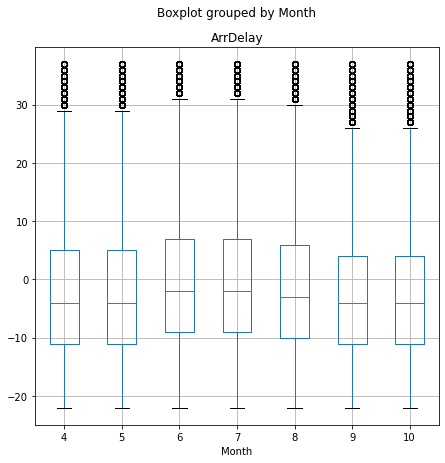

In [17]:
for col in delay_fields:
    df.boxplot(column=col, by='Month', figsize=(7, 7))

#### How do the day of week compare to arrival and departure delays?

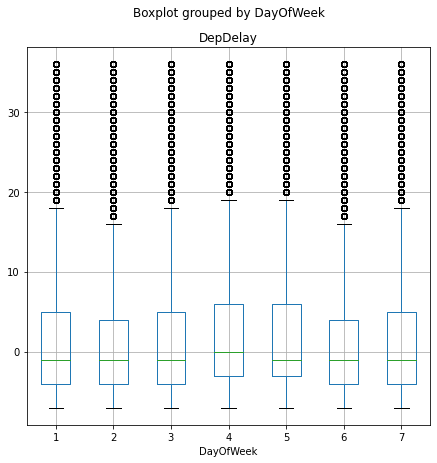

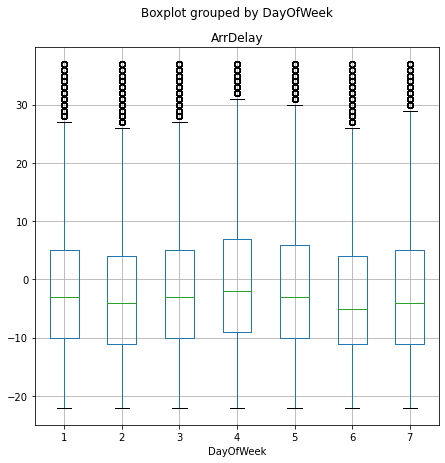

In [18]:
for col in delay_fields:
    df.boxplot(column=col, by='DayOfWeek', figsize=(7, 7))

#### How do the carrier compare to arrival and departure delays?

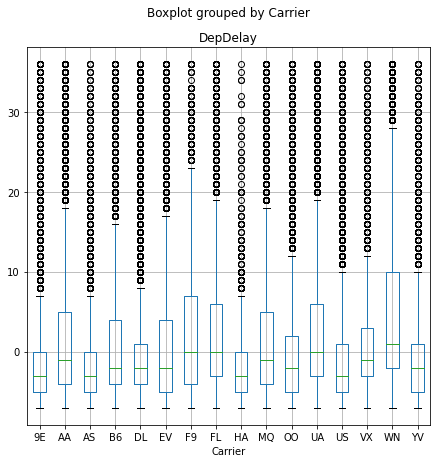

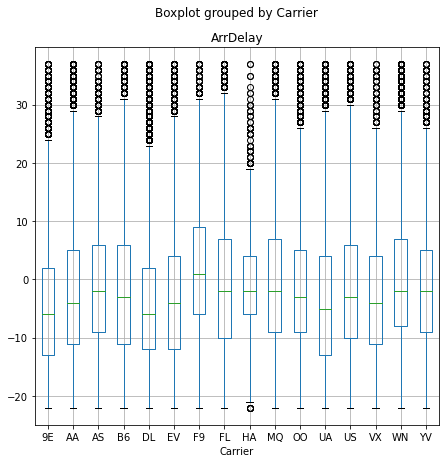

In [19]:
for col in delay_fields:
    df.boxplot(column=col, by='Carrier', figsize=(7, 7))

#### Which departure airport has the highest average departure delay?

In [20]:
departure_group = df.groupby(df['OriginAirportName'])

mean_delays = pd.DataFrame(departure_group['DepDelay'].mean())
mean_delays

,DepDelay
OriginAirportName,
Albuquerque International Sunport,2.914777
Austin - Bergstrom International,2.714684
Baltimore/Washington International Thurgood Marshall,4.593630
Bob Hope,2.088106
Bradley International,1.686735
...,...
Theodore Francis Green State,1.467742
Tucson International,0.581935
Washington Dulles International,1.843488


In [21]:
mean_delays = mean_delays.sort_values('DepDelay')
mean_delays

,DepDelay
OriginAirportName,
Long Beach Airport,-0.768473
Kahului Airport,-0.359763
Cincinnati/Northern Kentucky International,-0.090011
Ted Stevens Anchorage International,-0.008299
Memphis International,0.005356
...,...
Denver International,4.262430
Baltimore/Washington International Thurgood Marshall,4.593630
William P Hobby,5.348019


#### Do late departures tend to result in longer arrival delays that on-time departures?

In [22]:
# ...

#### Which route (from origin airport to destination airport) has the most late arrivals?

In [23]:
routes = pd.Series(df['OriginAirportName'] + '->' + df['DestAirportName'])
df = pd.concat([df, routes.rename("Route")], axis=1)
routes.value_counts()

San Francisco International->Los Angeles International           777
Los Angeles International->San Francisco International           677
McCarran International->Los Angeles International                582
Los Angeles International->McCarran International                578
Honolulu International->Kahului Airport                          559
                                                                ... 
Memphis International->Port Columbus International                 1
Bradley International->Cleveland-Hopkins International             1
Kahului Airport->Ted Stevens Anchorage International               1
Theodore Francis Green State->Southwest Florida International      1
Denver International->Kahului Airport                              1
Length: 2474, dtype: int64

In [ ]:
groupby_routes = df.groupby(df['Route'])
pd.DataFrame(groupby_routes['ArrDel15'].sum()).sort_values('ArrDel15')